In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

### Support Vector Machines

Many machine learning problems revolve around predicting class membership based on a high dimensional dataset or more simply classification. The goal in this notebook will be to explore the implementation of an SVM or 'Support Vector Machine' and uncover the math that lies underneath. 

Support Vector Machines are an incredibly potent tool for classification problems. (Note: SVM's can also be used for regression problems as well.)

The idea is that in N-dimensional space we can create a hyperplane that distinguishes a boundary that optimally determines class membership based on location of points in N-dimensional space in relation to the hyperplane.

We should also explore a very interesting property of svm's. When a hyperplane cannot be created that seperates classes in N dimensions the 'kernel trick' can be applied which using extremely powerful results from mathematics to generate a hyperplane in higher dimensions generating non-linear boundries in the original space.

### Defining the problem

Consider the graph below, we have 2 classes of objects represented by colors and a blue line passing through the middle of the graph splitting the plane in two with each class seperated on one side respectively. This is the decision boundary that an SVM would be asked to make for a linear decision boundary. The question is how can we format this problem mathematically and ultimately can we design a way to create an optimization problem to define this boundary line given a set of points like we have here?

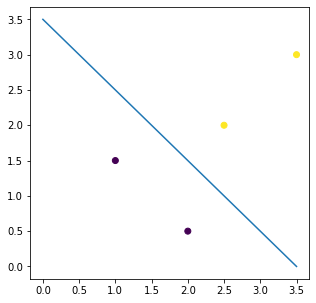

In [3]:
x=[2, 1, 2.5, 3.5]
y=[0.5, 1.5, 2, 3]
mem=[0, 0, 1, 1]
plt.figure(figsize=(5,5))
xlin=[0, 3.5]
ylin=[3.5, 0]
plt.scatter(x, y, c=mem)
plt.plot(xlin, ylin,scalex=False,scaley=False)

We start with some simple concepts in linear algebra. Suppose we take a vector from the origin that is assumed to be orthogonal to the decision plane. Lets call this vector $\overrightarrow w$. Note: we do not need to define a length. Further lets take some unknown point in the set of points in the data. Again from the origin we can represent this point in space with a vector call it $\overrightarrow u$. (For simplicity in notation we will simply use italic variables to denote vectors). Using the very familiar dot product we can find the projection of $u$ on $w$


Because we assume only that $w$ is orthogonal we can insist that $w$ is of unit length. This means our dot product of $u \cdot w$ now represents the $\underline {scalar}$ projection of $u$ onto $w$ as $||w|| = 1$. Now we can find out wether $u$ sits on the right or left side of decision boundary. We say that if $w \cdot u \geq c$ for some constant $c$ then $u$ is on the right side. Lets adjust this condition slightly to say $c=-b$ so we get $w \cdot u + b \geq 0$

To further alter this in our favor lets use this property we have above. Lets create a set of conditions that are satisfied when points lie either on the 'right' or 'left' side of the decision boundary.

A point that lies on the right should be $x_+$ and to the left $x_-$,
$$w \cdot x_+ + b \geq 1$$
$$w \cdot x_- + b \leq -1$$

It would be extremely convenient to have a single constraint function that works for any point $x_i$. So we make another simple adjustment.

Create a new variable $y_i$ such that:
$$y_i = 1, x_i = x_+$$
$$y_i = -1, x_i = x_-$$

If we multiply the above constraints by $y_i$ we have a single function:
$$y_i(w \cdot x_i + b) \geq 1$$
or
$$y_i(w \cdot x_i + b)-1 = 0$$ for points that maximize boundary

Lets use the idea of projections again to find the objective function of the optimization problem. The widest possible margin for the optimal decision boundary will be defined by the projection of the best $x_+$ onto $w$ minus the best $x_-$ projected onto $w$. This is equivalent to a line spanning the distance between these two points and it will run perpendicular to the decision plane. 

Represented in a formal equation the equation we want to maximize:

$$(x_+-x_-) \cdot \frac {w} {||w||}$$

Notice, taking information we have from above we know that:

$$x_+ \cdot w = 1-b$$
$$x_- \cdot w = -(1+b)$$

Our equation now becomes:
$$\frac {2} {||w||}$$

The equation now relies solely on the magnitude of w!

So: 
$$max \frac {2} {||w||} \equiv min||w|| \equiv min \frac{1}{2}||w||^2$$

Readjusting the equation in this way provides great convenience as we are about to introduce some calculus.
Namely we incorporate the use of Lagrange Multipliers to find the solution to the objective function subject to all the constraints generated from each datapoint in the set.

### Lagrange Multipliers and the Lagrangian dual

Lets formally define the Lagrange multiplier:

Lets assume we have a function f of which we wish to find either the min/max w.r.t some function g.
The Lagrange multiplier method says:
$$\nabla f(p) = \nabla \lambda g(p)$$
$$g(x)=0$$

Also viable to write as:
$$L(x,\alpha) = f(x)-\alpha g(x)$$
$$\nabla (x,\alpha)=0$$

We can structure our problem as a Lagrange dual problem. Important!:(when using a lagrangian dual if the primal optimization is a minimization then the dual is a maximization problem and vice versa.)

$$L = \frac{1}{2}||w||^2 - \sum \alpha_i(y_i(w \cdot x_i + b)-1)$$
$$\nabla L = \nabla (\frac{1}{2}||w||^2 - \sum \alpha_i(y_i(w \cdot x_i + b)-1)) = 0$$

Lets expand the gradient of this expression:

$$\frac {\partial L} {\partial w} = w - \sum \alpha_i y_i x_i = 0$$
$$\frac {\partial L} {\partial b} = \sum \alpha_i y_i = 0$$

Conviently we have an easy substitution:
$$ w = \sum \alpha_i y_i x_i$$

Lets see if we can use this substitution to find anything interesting in the original equations.
Making sure we use indexing that prevents any confusion.

$$L = \frac{1}{2}(\sum \alpha_j y_j x_j)^2 - \sum \alpha_i(y_i(\sum \alpha_j y_j x_j \cdot x_i + b)-1)$$

$$L = \frac{1}{2}(\sum \alpha_j y_j x_j)^2 - \sum \sum \alpha_i\alpha_jy_iy_jx_ix_j + b\sum a_iy_i - \sum\alpha_i$$

Some algebra on this term $\frac{1}{2}(\sum \alpha_j y_j x_j)^2$ shows:

$$max L = \sum \alpha_i - \frac {1}{2}\sum\sum \alpha_i\alpha_jy_iy_j x_ix_j$$

subject to:

$$\sum \alpha_i y_i = 0$$

The optimization problem only depends on pairs of samples from the dataset, and this is also a quadratic function of $\alpha$ making it very easy to solve with well known quadratic optimization algorithms!

### The Kernel Trick

the above example represents what is perhaps the most simplified version of this problem, its simplicity lends to an ease of explaining the mathematics involved in the principle idea behind SVMs. More often than not in practice the space within which we are working with respect to the data often requires complex non linear decision boundaries. Here is where the next most important idea of SVMs is developed.

Here are some examples of popular kernel functions:

The polynomial kernel:

$k(x_i,x_j) = (x_i \cdot x_j)^d$

The inhomogeneous polynomial:

$k(x_i,x_j) = (x_i \cdot x_j +r)^d$

The radial basis function:

$k(x_i, x_j)=exp(-\gamma||x_i-x_j||^2)$

The sigmoid function for some $\kappa >0$ and $c<0$:

$k(x_i, x_j)=tanh(\kappa x_i \cdot x_j + c)$

The main idea behind and the motivation or using kernel functions is that it allows us to compute an $\underline {implicit}$ feature space using only the inner products of samples via the inner product of the higher dimensional space. This is as opposed to computing every samples coordinates in the higher dimensional space, which is in comparison a much more arduous and computationally expensive process.

We employ the idea of inner products again. Using properties of 'kernel functions' we define a kernel which implicitly defines a feature space as:

$$k(x_i,x_j) = \langle \rho(x_i), \rho(x_j) \rangle$$

where:

$x_i,x_j \in \chi$ ,  $k:\chi \times \chi \to \mathbb{R}$

$\rho: \chi \to \nu$

If $\nu$ is an inner product space we actually do not need to explicitly compute $\rho$! This is provided k satisfies Mercers condition.

---
Historical footnote: The kernel trick was an idea originally discovered by Vladmir Vapnik the person credited with the discovery of the theory behind SVM. It wasn't until roughly 30 years after the original publication of his work that he along with Isabelle Guyon and Bernhard Boser, fully fleshed out the math behind the kernel trick and took SVM from an idea that had been shelved for decades to one of the most influential and powerful machine learning tools.

### Dataset
---
In this project I'll be using a large dataset consisting of information related to patients that have in some cases suffered heart attacks. Many dimensions are included in the data and as a method that identifies potential at risk groups would help tremendously to those trying to help prevent future patients from suffering heart attacks.

to get a sense of how the svm compares we can also build models using logistic regression as well as some tree classifiers

Before building the models we should first do some initial exploration of the data.

In [5]:
with open('C:\\Users\\sjmif\\Documents\\heart_data\\heart.csv') as f:
    data=pd.read_csv(f)
data.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [6]:
data.shape

(303, 14)

In [7]:
# correlation between variables

<AxesSubplot:>

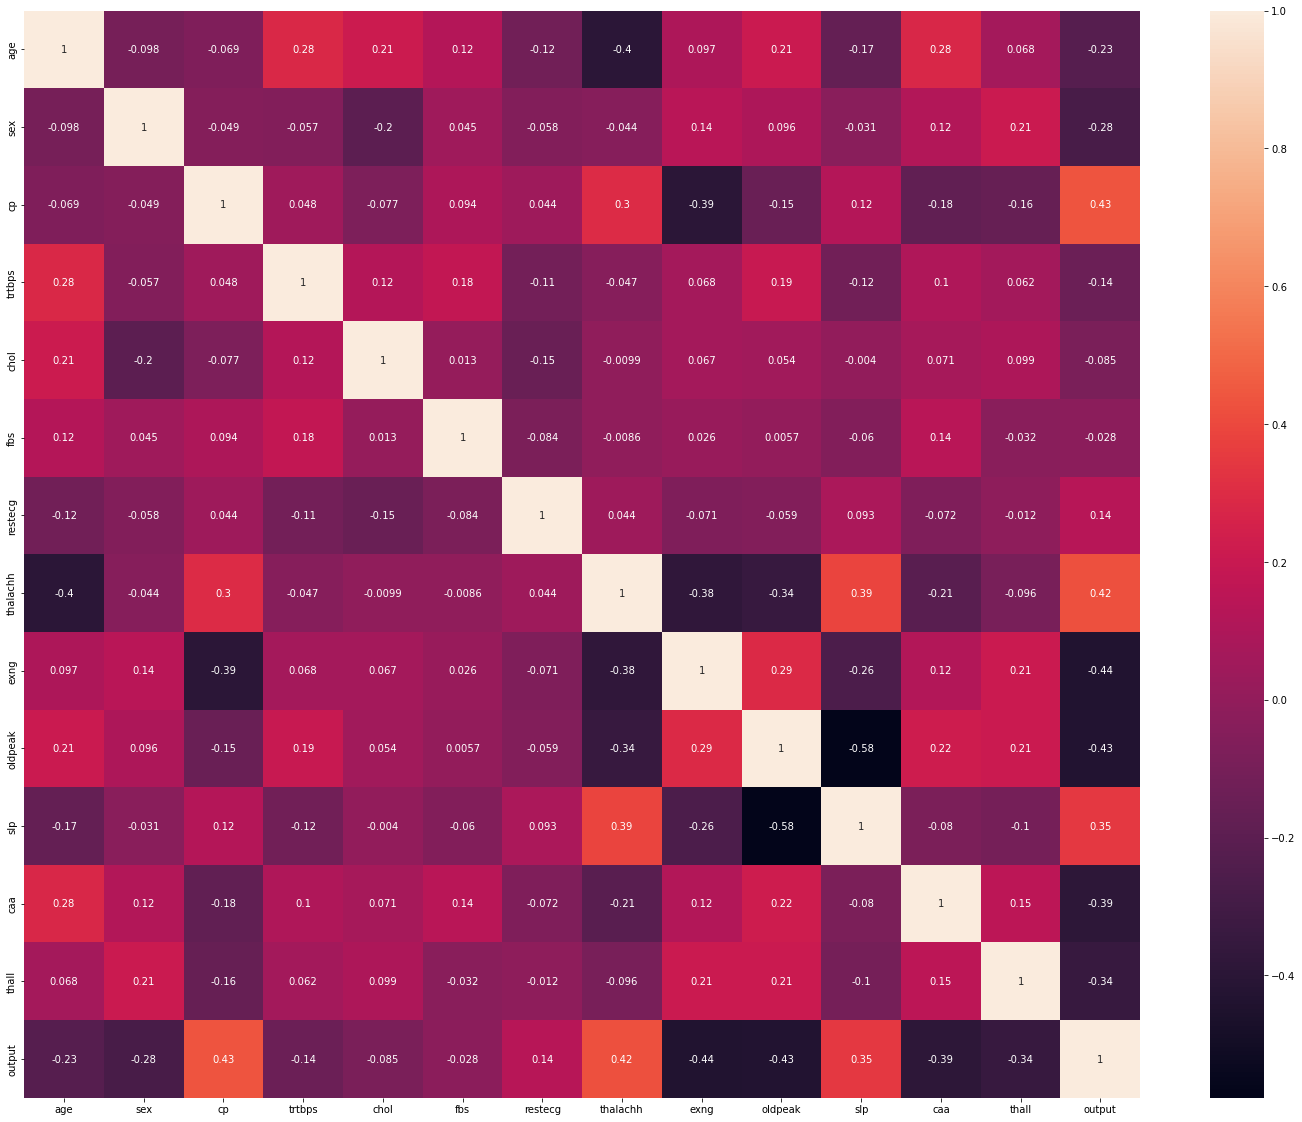

In [8]:
figure=plt.figure(figsize=(25, 20))
sns.heatmap(data=data.corr(), annot=True)

In [9]:
# distribution plots 

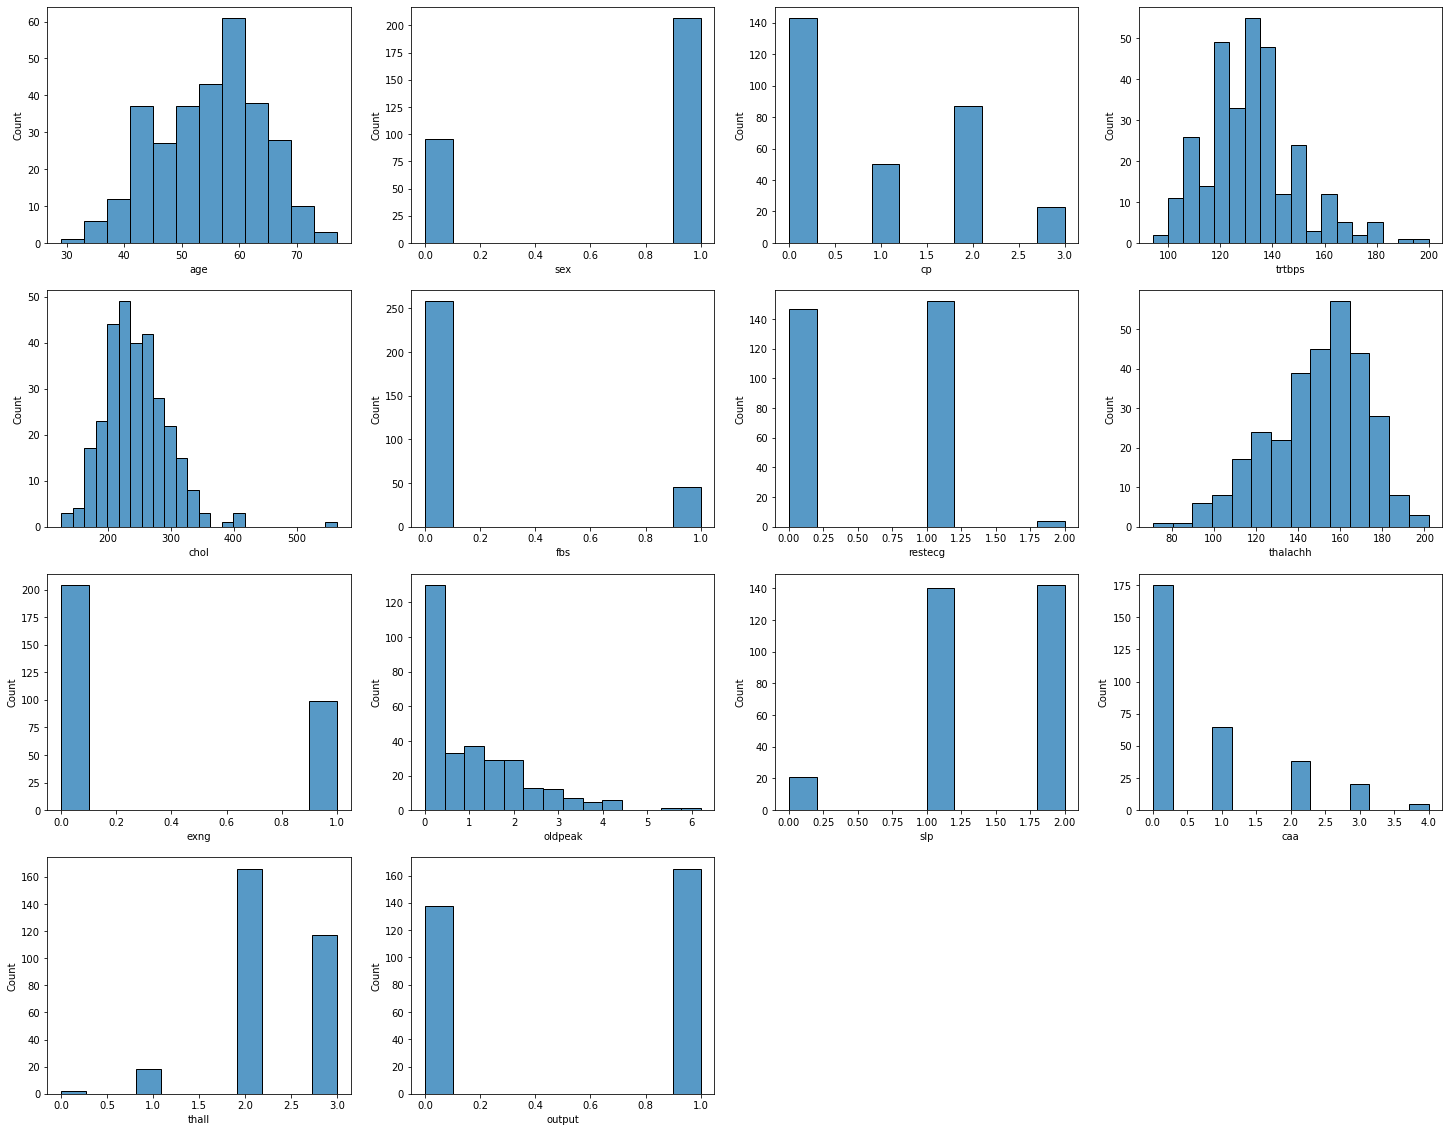

In [10]:
fig=plt.figure(figsize=(25,20))
k=1
for i in data.columns:
    plt.subplot(4,4,k)
    sns.histplot(data[i])
    k+=1

distribution plots to help visually understand each variables relationship with output. kernel density estimation allows taking discrete distributions and creating a smooth line graph of these features.

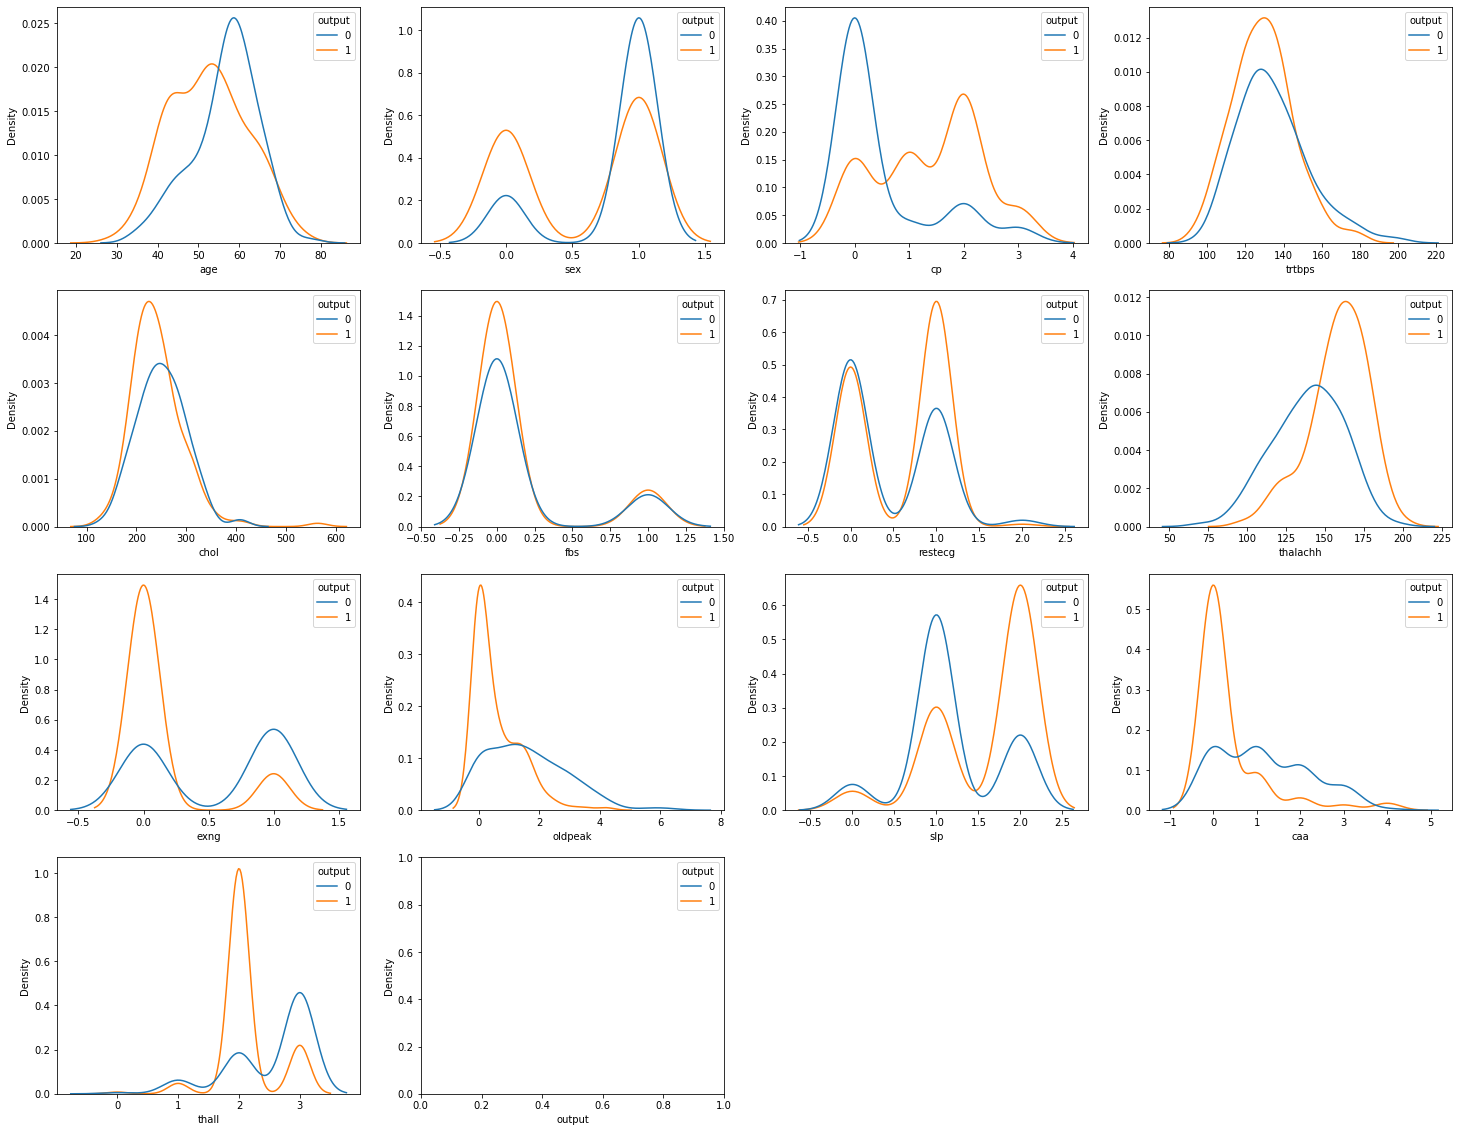

In [11]:
k=1
fig=plt.figure(figsize=(25,20))
for i in data.columns:
    plt.subplot(4,4,k)
    sns.kdeplot(x=data[i], hue=data['output'], warn_singular=False)
    k+=1

Some interesting and in some cases surprising effects, the age graph in particular clearly shows increase in age isnt as profound an indicator as I would expect it to be. Some other factors seem to indicate some clear patterns when comparing against output variable

## Data Preparation 

Data will need to be examined and adjusted before entered into the models we build to ensure computations can be made. Scaling and centering data is also a necessary process in addition to any changes made. The way the svm was explained to work it is easy to see if some features exist on a wider scale with greater variance its possible the algorithm will prioritize using these features to split. We want all features in theory to contribute to the decision boundary that is created with equal magnitude.

In [12]:
#check for missing data
data.isna().any()

age         False
sex         False
cp          False
trtbps      False
chol        False
fbs         False
restecg     False
thalachh    False
exng        False
oldpeak     False
slp         False
caa         False
thall       False
output      False
dtype: bool

In [13]:
# do we have any categorical data that would need to be encoded, or any other data types that might cause problems? No.
data.dtypes

age           int64
sex           int64
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64
caa           int64
thall         int64
output        int64
dtype: object

In [14]:
# Scaling and test train split for validation.
datatr, datats = train_test_split(data, test_size=0.2, random_state=1)

In [15]:
# Sklearns standard scaler centers and normalizes our data which will ultimately prove necessary.

scaler=StandardScaler()
datatr_sc=scaler.fit_transform(datatr)
datats_sc=scaler.transform(datats) #only transform test data, only fitting should be performed on training set.

In [16]:
# For convenience turn numpy arrays created from scaler back into pandas dataframes
datatr=pd.DataFrame(data=datatr_sc, columns=data.columns)
datats=pd.DataFrame(data=datats_sc, columns=data.columns)

In [17]:
#check to confirm transformation
datatr.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,-0.270906,0.663684,1.976649,-0.770147,-1.174488,-0.418040,-1.027355,1.721500,-0.68313,-0.933529,-0.668965,-0.724286,-2.117019,0.897758
1,1.370810,-1.506742,0.998430,1.186855,0.595846,-0.418040,0.885106,0.955920,-0.68313,-0.933529,0.966282,0.271607,-0.474972,0.897758
2,0.276333,0.663684,0.998430,1.071737,-2.341741,2.392117,0.885106,0.998453,-0.68313,-0.751046,0.966282,0.271607,1.167074,0.897758
3,0.276333,0.663684,0.020211,1.301972,-0.279594,-0.418040,-1.027355,0.615663,-0.68313,-0.933529,0.966282,0.271607,-0.474972,-1.113885
4,-0.489801,-1.506742,0.020211,-0.655030,-0.046143,-0.418040,0.885106,0.530598,-0.68313,0.070128,0.966282,-0.724286,-0.474972,0.897758


In [18]:
datatrX=datatr.drop(labels='output', axis=1)
datatrY=datatr['output']

In [19]:
datatsX=datats.drop(labels='output', axis=1)
datatsY=datats['output']

In [20]:
enc = LabelEncoder()

In [21]:
datatrY = enc.fit_transform(datatrY)

In [22]:
datatsY = enc.transform(datatsY)

In [23]:
datatsY

array([0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1], dtype=int64)

In [24]:
clf = SVC(C=0.1)
clf.fit(datatrX, datatrY)

SVC(C=0.1)

In [25]:
clf.score(datatsX, datatsY)

0.8032786885245902

### Cross Validation

The results above are not bad, however much like other methods, sklearns SVM module also has a variety of hyperparameters both in choice of functions as well as tuning parameters within each. Consequently the use of a grid search cross validation approach should help to quickly determine an optimal choice of these inputs, and verify that these are infact good models.

In [26]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold 

In [27]:
svmest = SVC()
paragrid = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'),'C':(np.linspace(0.09, 0.1, 20))}
clf = GridSearchCV(
    svmest, param_grid=paragrid,
    cv=RepeatedKFold(n_splits=10, n_repeats=3, random_state=1),
    n_jobs=-1,
    return_train_score=True
)

In [28]:
clf.fit(datatrX, datatrY)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([0.09      , 0.09052632, 0.09105263, 0.09157895, 0.09210526,
       0.09263158, 0.09315789, 0.09368421, 0.09421053, 0.09473684,
       0.09526316, 0.09578947, 0.09631579, 0.09684211, 0.09736842,
       0.09789474, 0.09842105, 0.09894737, 0.09947368, 0.1       ]),
                         'kernel': ('linear', 'poly', 'rbf', 'sigmoid')},
             return_train_score=True)

In [29]:
clf.best_params_

{'C': 0.09, 'kernel': 'linear'}

In [30]:
clf.best_score_

0.8401666666666666

The above results indicate after grid searching and cross validating we have actually selected a linear kernel with a different parameter for C compared to the first SVM created with default values. We can see with the improved results, the importance of this step when using models with a number of different hyperparameters to choose from.